In [513]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.statespace.sarimax import SARIMAX


1   -0.639999
2   -0.380005
3    2.130005
4    5.369995
5    1.930000
Name: Close, dtype: float64


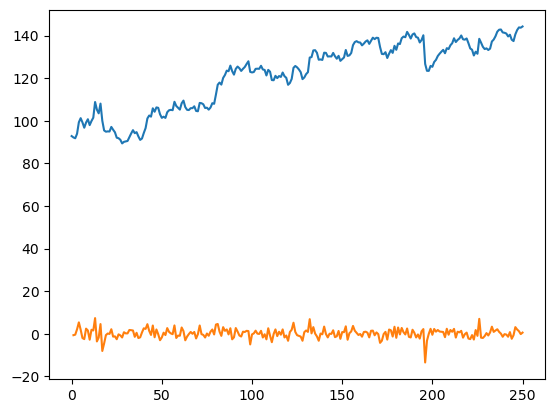

In [514]:

df = pd.read_csv('GOOG.csv')
#print(df.head())
plt.plot(df['Close'])


# This is how the Videos made the Data Stationary(Or close to stationary)
modified_Close = df['Close'] - df['Close'].shift(1)
modified_Close = modified_Close.dropna()
print(modified_Close.head())
plt.plot(modified_Close)
#The length in the modified_Close data starts from 3 Jan, 


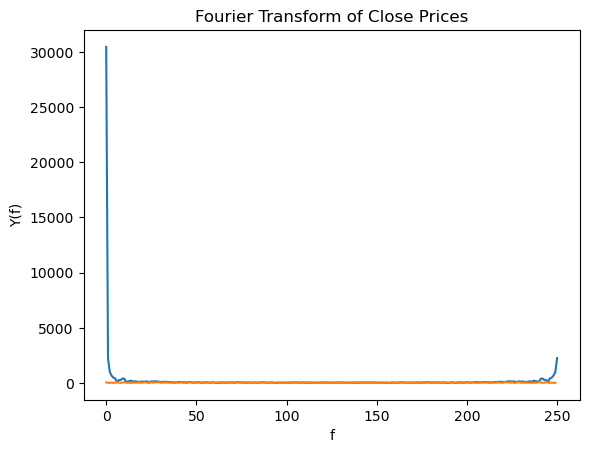

In [515]:
fourier_transform = np.fft.fft(df['Close'])
fourier_transform_2 = np.fft.fft(modified_Close)
plt.plot(np.abs(fourier_transform))
plt.plot(np.abs(fourier_transform_2))
plt.xlabel('f')
plt.ylabel('Y(f)')
plt.title('Fourier Transform of Close Prices')
plt.show()


### The Interpretation
The Modified Close does not give any major peaks in the Fourier Transform which is a sign that the fluctuating components are very less, this suggests that the modified Close is having stationarity, further tests will further test this property

### ACF or Autocorellation function
This lags the data by a certain amout and finds out the correlation between the distributions thus formed and the current distribution

### PACF or Partial Autocorellation function
This is mathematically defined as the corellation of xt and xt-n with respect to the variables xt-1, xt-2 .... xt-n+1, here the lag is set to 30 which means the PACF of lag 1....30 will be plotted

#### We have 20 days in december with data avaliable in them, as per the instructions to build the hybrid model, lets predict those details in the end result

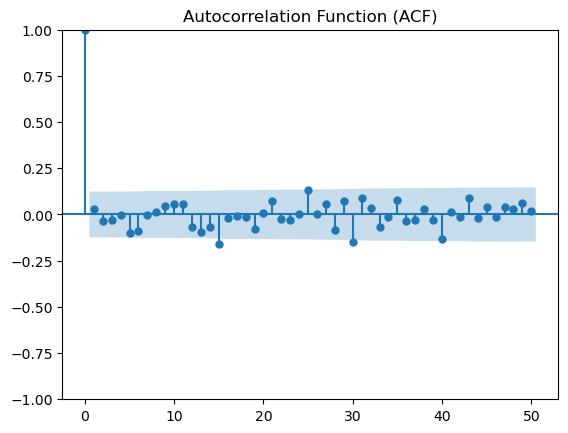

c:\Users\moond\anaconda3\Lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


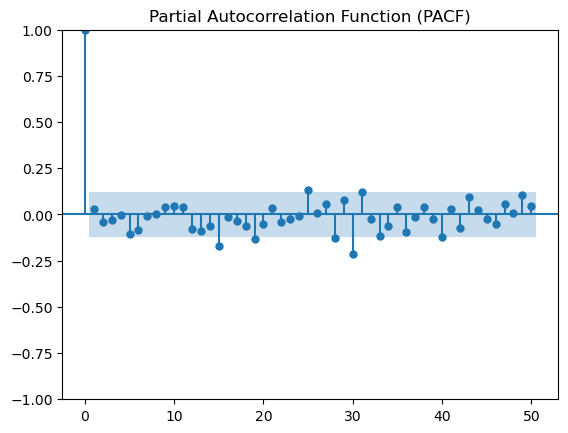

In [516]:
plot_acf(modified_Close, lags=50)
plt.title('Autocorrelation Function (ACF)')
plt.show()

# Plot PACF
plot_pacf(modified_Close, lags=50)
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()


In [517]:
result = adfuller(modified_Close)
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'\t{key}: {value}')

ADF Statistic: -15.237433658174778
p-value: 5.218971687281002e-28
Critical Values:
	1%: -3.4568881317725864
	5%: -2.8732185133016057
	10%: -2.5729936189738876


The Arima model will be a decent fit here, as the data appears visully stationary and the PACF and ACF tests all give us insights in the value of p, q, d  required.
The p ~ 30 as the ACF shows a significant value around the 30th lag, meaning the S(t-30) information to be useful in predicting the current value.
The q ~ value can be kept 40-45 as there are peaks there in that region in the PACF graph.
The d can be kept 0 as we have already subtracted and made the model stationary that way


c:\Users\moond\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\moond\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\moond\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\moond\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\moond\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA paramete

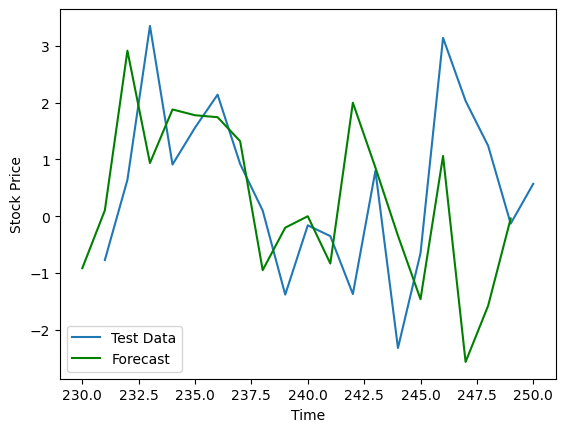

In [518]:
p = 31
d = 0
q = 33
train_size = int(len(modified_Close) * 230/250)
train, test = modified_Close[:train_size], modified_Close[train_size:]

# Fit ARIMA model on the training data
model = ARIMA(train, order=(p, d, q))
fitted_model = model.fit()

forecast = fitted_model.forecast(steps=len(test))


# Plotting the original test data and the forecasted values
plt.plot(test, label='Test Data')
plt.plot(forecast, color='green', label='Forecast')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


Alright, so now we have a model -
As is expected from an AR model, the error keeps increasing over time, and in the end the results are just completely incorrect(last few days)
now lets work on the second model to get be able to predict those errors as well

c:\Users\moond\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


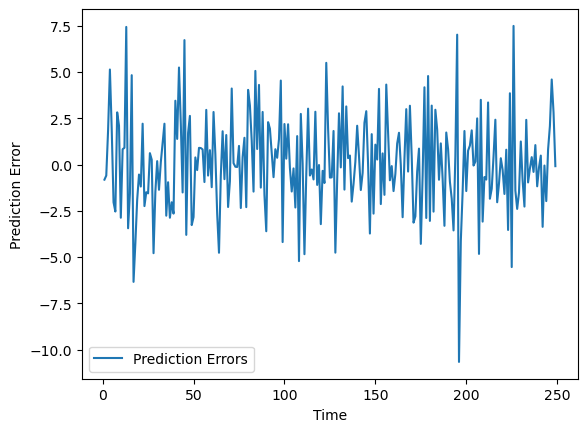

In [519]:

mct = test
total_forecast = fitted_model.predict(start=0, end=len(modified_Close)-1, typ='levels')
errors = modified_Close - total_forecast

# Create a DataFrame to store the errors
errors_df = pd.DataFrame({'Actual': train, 'Predicted': total_forecast, 'Error': errors})

# Display or save the errors DataFrame as needed
# print(errors_df)

# Optionally, you can plot the errors
plt.plot(errors_df['Error'], label='Prediction Errors')
plt.xlabel('Time')
plt.ylabel('Prediction Error')
plt.legend()
plt.show()

errors = errors_df['Error']






#### These are errors that we received in test and train (Though the AR model was not trained on the test data)
#### Now to train the errors on the train data, and then try to fit a model on the test data.

In [520]:
# split the errors into train and test

training_size = int(len(errors)*230/250)

# column_to_scale = errors.values.reshape(-1, 1)
# scaler = MinMaxScaler()
# scaled_column = scaler.fit_transform(column_to_scale)
# errors = pd.DataFrame(scaled_column)

training_error, testing_error = errors[0:training_size], errors[training_size-6:len(errors)] 

In [521]:
def create_dataset(dataset, time_step=1):
    data_X = []
    data_Y = []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i: (i+time_step)]  
        data_X.append(a)
        data_Y.append(dataset[i+time_step])
    return np.array(data_X), np.array(data_Y)



In [522]:
time_step = 5
training_error_array, testing_error_array = training_error.values, testing_error.values
X_train, y_train = create_dataset(training_error_array, time_step)
X_test, y_test = create_dataset(testing_error_array, time_step)

print(X_train.shape)
print(X_test.shape)



(224, 5)
(21, 5)


In [523]:
X_train = X_train[~np.isnan(X_train).any(axis=1)]
y_train = y_train[1:]



In [524]:
X_train_LSTM = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_LSTM = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# as the LSTM model takes in inputs like (samples, time_steps, features)

In [525]:
model = Sequential()
hidden_layer_neurons = 20
model.add(LSTM(hidden_layer_neurons, return_sequences=True, input_shape=(5, 1)))
model.add(LSTM(hidden_layer_neurons, return_sequences=True))
model.add(LSTM(hidden_layer_neurons))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer='adam')

In [526]:
# model.summary()
model.fit(X_train_LSTM, y_train, validation_data=(X_test_LSTM, y_test),epochs=100, batch_size=64, verbose=1)

Epoch 1/100
4/4 [==============================] - 10s 416ms/step - loss: 6.9324 - val_loss: 3.2690
Epoch 2/100
4/4 [==============================] - 0s 19ms/step - loss: 6.9293 - val_loss: 3.2681
Epoch 3/100
4/4 [==============================] - 0s 21ms/step - loss: 6.9292 - val_loss: 3.2705
Epoch 4/100
4/4 [==============================] - 0s 17ms/step - loss: 6.9274 - val_loss: 3.2685
Epoch 5/100
4/4 [==============================] - 0s 17ms/step - loss: 6.9271 - val_loss: 3.2702
Epoch 6/100
4/4 [==============================] - 0s 17ms/step - loss: 6.9262 - val_loss: 3.2670
Epoch 7/100
4/4 [==============================] - 0s 17ms/step - loss: 6.9244 - val_loss: 3.2660
Epoch 8/100
4/4 [==============================] - 0s 17ms/step - loss: 6.9236 - val_loss: 3.2636
Epoch 9/100
4/4 [==============================] - 0s 16ms/step - loss: 6.9223 - val_loss: 3.2626
Epoch 10/100
4/4 [==============================] - 0s 13ms/step - loss: 6.9215 - val_loss: 3.2614
Epoch 11/100
4/4 

In [527]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
import math
from sklearn.metrics import mean_squared_error

# test_predict = scaler.inverse_transform(test_predict)
# y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
# train_predict = scaler.inverse_transform(train_predict)
# y_train = scaler.inverse_transform(y_train.reshape(-1, 1))

math.sqrt(mean_squared_error(y_test, test_predict))


1/1 [==============================] - 0s 20ms/step


2.2585963232827235

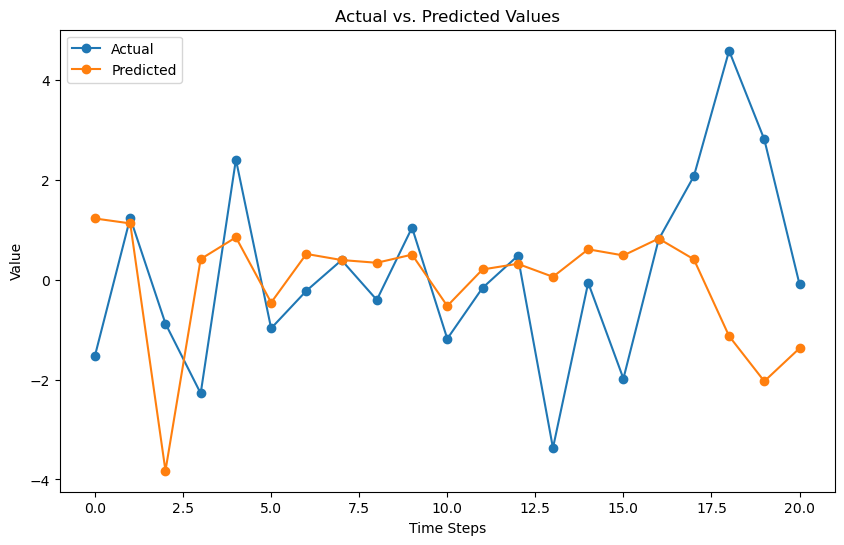

In [528]:
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual', marker='o')
plt.plot(test_predict, label='Predicted', marker='o')
plt.title('Actual vs. Predicted Values')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.legend()
plt.show()


In [544]:
test_predict_data = pd.DataFrame(test_predict)
# print(test_predict_data)

# forecast = forecast[:len(result)]

forecast_reindexed = forecast.reset_index(drop=True)
# forecast_reindexed

result_f = forecast_reindexed  + test_predict_data

result_f = result_f.iloc[:, 0]

mct_f = mct.reset_index(drop=True)


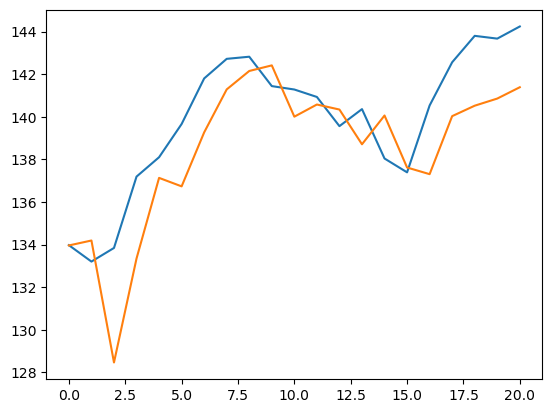

In [543]:

og_22 = df['Close'].tail(22).reset_index(drop=True)
og_21 = df['Close'].tail(21).reset_index(drop=True)
result_f
indices_to_pick = range(0, 21)
og_shifted = og_22.loc[indices_to_pick]
pred = og_shifted + result_f

plt.plot(og_21)
plt.plot(pred)


